In [12]:
!git branch
!git checkout TFT
!git branch

* TFT
  main
M	TFT/Residential/TFT_CNI.ipynb
M	TFT/Residential/TFT_LNI.ipynb
M	TFT/Residential/TFT_LSI.ipynb
M	TFT/Residential/TFT_UNI.ipynb
M	TFT/Residential/TFT_USI.ipynb
Your branch is ahead of 'origin/TFT' by 2 commits.
  (use "git push" to publish your local commits)


Already on 'TFT'


* TFT
  main


In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from torch.nn import MSELoss
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

# Weather Dataset

In [15]:
electricity_consumption = pd.read_csv("../../ProcessedData/Electricity-ResBusClimateUSI.csv")
electricity_consumption.drop(['Import values', 'Export values'], axis=1, inplace=True)
electricity_consumption

,Date,Total Rainfall Mm,Mean Air Temperature in Celsius,Mean Vapour Pressure Hpa,Mean Wind Speed M/Sec,Days Of Wind Gust >= 24 Knots in Day,Standard Deviation Of Daily Mean Temperature in Celsius,Year,Month,Selected business demand (GWh),Est. Total consumption (GWh),Export prices,Export volumes,Import prices,Import volumes,Population
0,2010-01-01,96.800000,17.225,14.150,3.975,13.500000,2.375,2010.0,1.0,311.578,150.884,1072.0,1160.0,904.0,1360.0,739000.0
1,2010-02-01,43.000000,17.900,14.825,3.550,7.666667,1.850,2010.0,2.0,308.803,140.886,1072.0,1160.0,904.0,1360.0,739000.0
2,2010-03-01,49.225000,16.025,12.450,4.100,16.666667,2.275,2010.0,3.0,344.876,160.673,1072.0,1160.0,904.0,1360.0,739000.0
3,2010-04-01,52.700000,13.975,11.775,3.675,10.333333,2.325,2010.0,4.0,293.250,174.629,1112.0,1264.0,920.0,1476.0,739000.0
4,2010-05-01,164.825000,10.900,10.725,3.075,6.000000,2.225,2010.0,5.0,284.488,216.421,1112.0,1264.0,920.0,1476.0,739000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,2024-02-01,61.133333,16.950,13.400,4.000,12.500000,2.050,2024.0,2.0,350.008,151.908,1362.0,1465.0,998.0,2381.0,866400.0
170,2024-03-01,59.300000,14.550,11.825,3.900,14.250000,2.650,2024.0,3.0,340.900,179.446,1362.0,1465.0,998.0,2381.0,866400.0
171,2024-04-01,124.000000,13.375,11.900,3.625,11.333333,2.450,2024.0,4.0,291.942,195.360,1433.0,1584.0,1029.0,2414.0,866400.0
172,2024-05-01,47.950000,9.175,8.925,2.825,5.750000,1.775,2024.0,5.0,295.384,275.921,1433.0,1584.0,1029.0,2414.0,866400.0


In [16]:
# Convert dataframe to Timeseries
ts = TimeSeries.from_dataframe(electricity_consumption, time_col="Date" )

In [17]:
# training and validation split
training_cutoff = pd.Timestamp('2021-01-01')
train, val = ts.split_before(training_cutoff)

In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))
transformer = Scaler(scaler)
transformer_target = Scaler(scaler)

train_target_og = train['Est. Total consumption (GWh)']
val_target_og = val['Est. Total consumption (GWh)']
train_target = transformer_target.fit_transform(train_target_og)
val_target = transformer_target.transform(val_target_og)

train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(ts)

#split past covariates
train_past_cov = train_transformed[
    [ 
        'Mean Air Temperature in Celsius', 
        'Mean Vapour Pressure Hpa',
    ]
]
# replace missing value with the mean of column
train_past_cov = train_past_cov.pd_dataframe()
train_past_cov = train_past_cov.apply(lambda col: col.fillna(col.mean()))
train_past_cov = TimeSeries.from_dataframe(train_past_cov)

In [19]:
series_transformed = series_transformed.pd_dataframe()
series_transformed = series_transformed.apply(lambda col: col.fillna(col.mean()))
series_transformed = TimeSeries.from_dataframe(series_transformed)

# Model Training Forecasting

In [9]:
# with past covariates
input_chunk_length = 72
forecast_horizon = 42

my_model_withpast = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=120,
    lstm_layers=3,
    num_attention_heads=3,
    dropout=0.1,
    batch_size=64,
    n_epochs=150,
    add_relative_index=False,
    add_encoders={
        'cyclic': {'past': ['month']},  
        'datetime_attribute': {'future': ['month', 'year']},
    },
    loss_fn=MSELoss(),
    likelihood=None,
    random_state=5,
    optimizer_kwargs={"lr": 1e-2}, 
)
my_model_withpast.fit(train_target, past_covariates = train_past_cov, verbose=True)

Training: |                                                                                      | 0/? [00:00<…

NameError: name 'exit' is not defined

In [16]:
# without past covariates
input_chunk_length = 72
forecast_horizon = 42

my_model_nopast = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=120,
    lstm_layers=3,
    num_attention_heads=3,
    dropout=0.1,
    batch_size=64,
    n_epochs=150,
    add_relative_index=False,
    add_encoders={
        'cyclic': {'past': ['month']},  
        'datetime_attribute': {'future': ['month', 'year']},
    },
    loss_fn=MSELoss(),
    likelihood=None,
    random_state=5,
    optimizer_kwargs={"lr": 1e-2}, 
)

my_model_nopast.fit(train_target, verbose=True)

Training: |                                                                                      | 0/? [00:00<…

TFTModel(output_chunk_shift=0, hidden_size=120, lstm_layers=3, num_attention_heads=3, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=MSELoss(), likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=72, output_chunk_length=42, batch_size=64, n_epochs=150, add_encoders={'cyclic': {'past': ['month']}, 'datetime_attribute': {'future': ['month', 'year']}}, random_state=5, optimizer_kwargs={'lr': 0.01})

In [22]:
from darts.metrics import mape, mae, rmse

Predicting: |                                                                                    | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

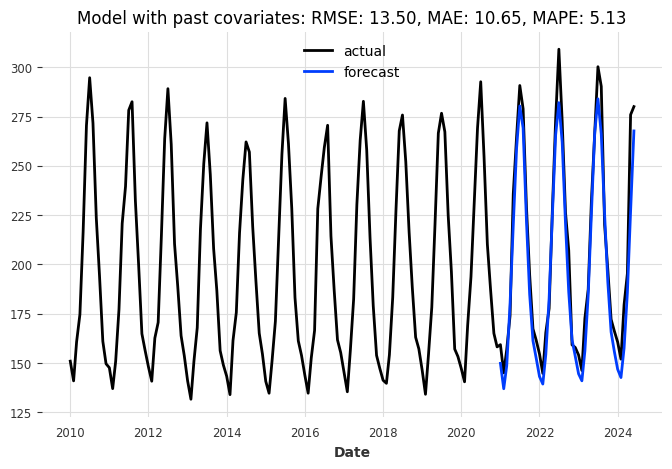

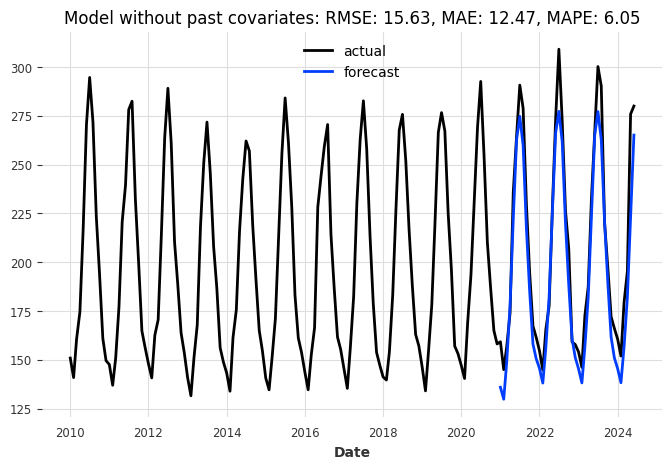

In [27]:
def eval_model(model, num):
    pred_series = model.predict(n=42)
    plt.figure(figsize=(8, 5))
    pred_series_reversed = transformer_target.inverse_transform(pred_series)
    ts['Est. Total consumption (GWh)'].plot(label="actual")
    pred_series_reversed['Est. Total consumption (GWh)'].plot(label="forecast")
    if num == 1:
        plt.title("Model with past covariates: RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}".format(rmse(val_target_og, pred_series_reversed), mae(val_target_og, pred_series_reversed), mape(val_target_og, pred_series_reversed)))
        plt.legend()
        return pred_series
    else:
        plt.title("Model without past covariates: RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}".format(rmse(val_target_og, pred_series_reversed), mae(val_target_og, pred_series_reversed), mape(val_target_og, pred_series_reversed)))
        plt.legend()
        return pred_series

pred_series_transformed = eval_model(my_model_withpast, 1)
pred_series_transformed_no_past_cov = eval_model(my_model_nopast, 0)

# Backtesting

In [20]:
model_TFT_backtest = TFTModel(
    input_chunk_length=66,
    output_chunk_length=3,
    hidden_size=120,
    lstm_layers=3,
    num_attention_heads=3,
    dropout=0.1,
    batch_size=64,
    n_epochs=100,
    add_relative_index=False,
    add_encoders={
        'cyclic': {'past': ['month']},  
        'datetime_attribute': {'future': ['month', 'year']},
    },
    loss_fn=MSELoss(),
    likelihood=None,
    random_state=5,
    optimizer_kwargs={"lr": 1e-2},
)


Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

NameError: name 'rmse' is not defined

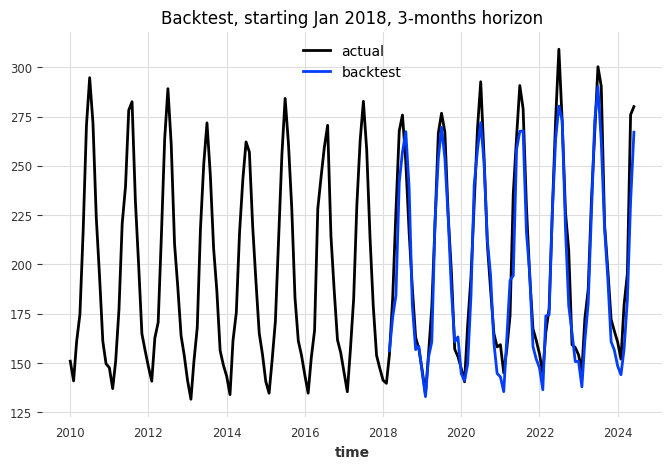

In [21]:
# with past covariates
backtest_series_with = model_TFT_backtest.historical_forecasts(
    series_transformed['Est. Total consumption (GWh)'],               
    past_covariates=series_transformed[['Mean Air Temperature in Celsius', 'Mean Vapour Pressure Hpa']],   
    start=pd.Timestamp("20180101"),
    forecast_horizon=3,
    retrain=True,
    verbose=False,
)

backtest_series_reversed_with = transformer_target.inverse_transform(backtest_series_with)



MAPE: 5.25%, RMSE: 14.57


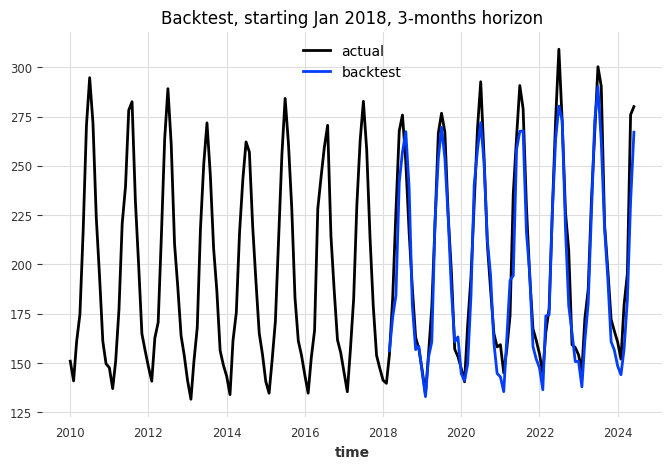

In [23]:
plt.figure(figsize=(8, 5))
ts['Est. Total consumption (GWh)'].plot(label="actual")
backtest_series_reversed_with.plot(label="backtest")
plt.legend()
plt.title("Backtest, starting Jan 2018, 3-months horizon")
print(
    "MAPE: {:.2f}%, RMSE: {:.2f}".format(
        mape(
            ts['Est. Total consumption (GWh)'],
            backtest_series_reversed_with,
        ),
        rmse(
            ts['Est. Total consumption (GWh)'],
            backtest_series_reversed_with,
        )
    )
)

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

MAPE: 4.43%, RMSE: 12.07


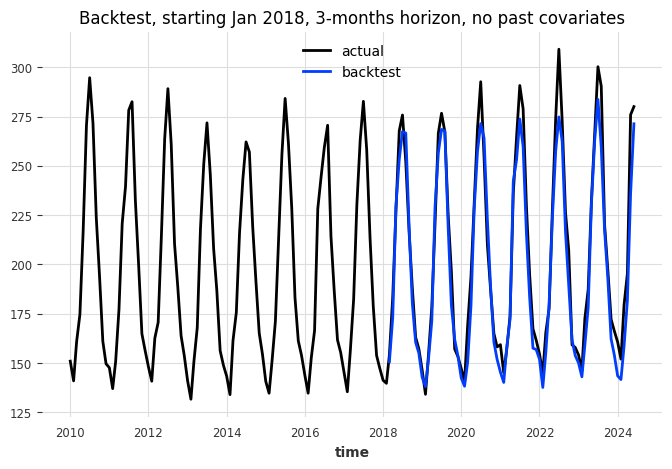

In [24]:
# without past covariates
backtest_series_without = model_TFT_backtest.historical_forecasts(
    series_transformed['Est. Total consumption (GWh)'],
    start=pd.Timestamp("20180101"),
    forecast_horizon=3,
    retrain=True,
    verbose=False,
)

backtest_series_reversed_without = transformer_target.inverse_transform(backtest_series_without)

plt.figure(figsize=(8, 5))
ts['Est. Total consumption (GWh)'].plot(label="actual")
backtest_series_reversed_without.plot(label="backtest")
plt.legend()
plt.title("Backtest, starting Jan 2018, 3-months horizon, no past covariates")
print(
    "MAPE: {:.2f}%, RMSE: {:.2f}".format(
        mape(
            ts['Est. Total consumption (GWh)'],
            backtest_series_reversed_without,
        ),
        rmse(
            ts['Est. Total consumption (GWh)'],
            backtest_series_reversed_without,
        )
    )
)

In [25]:
# Assuming 'backtest_series_reversed' is already available and converted to pandas DataFrame
backtest_series_df = backtest_series_reversed_with.pd_dataframe()

# Save the DataFrame to a CSV file
csv_file_path = './Result_res/TFT/USI/res.csv'
backtest_series_df.to_csv(csv_file_path)

csv_file_path

'./Result_res/TFT/USI/res.csv'